# Keras ConvLSTM2D network

Use a network made of convolutional LSTM layers.

In [1]:
import numpy as np
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
import keras.backend as K
import imageio
from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
import random

import sys
sys.path.append('..')
import SequenceLineFilterLayer

Using TensorFlow backend.


## Model

In [2]:
model = load_model("model/LSTMCategorical.h5")

IOError: Unable to open file (Unable to open file: name = 'model/lstmcategorical.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

## Data

Full games are represented as image sequences ("movies"). The network has to predict the next frame of an unfinished sequence.

The input data is the full game without the last state where all lines are filled in. The output data is the full game without the very first state where no lines are drawn.

In [3]:
sequenceDataset = np.load('sequence5x4.npz')
games = sequenceDataset['games']
print(games.shape)

(1000, 49, 11, 13)


In [4]:
seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(5, 5),
                   input_shape=(None, None, None, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(5, 5),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(5, 5),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(5, 5),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(5, 5),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(5,5,5), padding='same'))

seq.add(SequenceLineFilterLayer.SequenceLineFilterLayer(games.shape[-1], games.shape[-2], noShapeCheck=True))

seq.add(Activation('softmax'))

seq.compile(loss='categorical_crossentropy', optimizer='adadelta')

model = seq
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, None, None,  164160    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, None,  160       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, None, None,  320160    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, None,  160       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, None, None,  320160    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, None, None,  160       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, None, None, None,  320160    
__________

In [5]:
for layer in model.layers:
    print(layer.output_shape)

(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 40)
(None, None, None, None, 1)
(None, None, None)
(None, None, None)


In [6]:
def imgSizeToBoxes(x):
    return (x-3)/2

def lineFilterMatrixNP(imgWidth,imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=np.bool)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = 1
    return mat

lineFilterMatrixNP(13,11)

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True,

In [7]:
x_train = games[:,:-1,:,:]
y_train = np.subtract(games[:,0:-1,:,:], games[:,1:,:,:])[:,:,lineFilterMatrixNP(x_train.shape[-1], x_train.shape[-2])]
print(x_train.shape)
print(y_train.shape)

print(y_train[23,10])
print(np.subtract(games[23,0:-1,:,:], games[23,1:,:,:])[10])

x_train = x_train.astype(K.floatx())
y_train = y_train.astype(K.floatx())
#x_train /= 255
#y_train /= 255

(1000, 48, 11, 13)
(1000, 48, 49)
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [8]:
np.set_printoptions(precision=2, suppress=True, linewidth=90)

exampleGameIdx = 23
exampleGameFrame = 10

print(x_train[exampleGameIdx,exampleGameFrame])
print(y_train[exampleGameIdx,exampleGameFrame])

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 215.   0. 215.   0. 215.   0. 215.   0. 215.   0. 215.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 255.   0.   0.   0.]
 [  0. 215.   0. 215.   0. 215.   0. 215. 255. 215.   0. 215.   0.]
 [  0.   0.   0.   0.   0. 255.   0.   0.   0. 255.   0.   0.   0.]
 [  0. 215.   0. 215. 255. 215.   0. 215.   0. 215. 255. 215.   0.]
 [  0.   0.   0.   0.   0. 255.   0.   0.   0. 255.   0.   0.   0.]
 [  0. 215. 255. 215.   0. 215.   0. 215. 255. 215.   0. 215.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 215.   0. 215.   0. 215.   0. 215. 255. 215.   0. 215.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
x_train = x_train.reshape(x_train.shape + (1,))
print(x_train.shape)

(1000, 48, 11, 13, 1)


## Training

In [10]:
#model.fit(x_train[0:8:1,:,:,:,:], y_train[0:8:1,:,:,:,:], epochs=50, batch_size=16)
model.fit(x_train[:900], y_train[:900], batch_size=10,
        epochs=20, validation_split=0.05)


Train on 855 samples, validate on 45 samples
Epoch 1/20
855/855 [==============================] - 122s 143ms/step - loss: 4.7729 - val_loss: 3.7560
Epoch 2/20
855/855 [==============================] - 119s 140ms/step - loss: 1.6678 - val_loss: 0.2126
Epoch 3/20
855/855 [==============================] - 119s 140ms/step - loss: 0.0037 - val_loss: 0.0298
Epoch 4/20
855/855 [==============================] - 119s 140ms/step - loss: 4.6381e-04 - val_loss: 0.0040
Epoch 5/20
855/855 [==============================] - 119s 140ms/step - loss: 1.0994e-04 - val_loss: 7.7366e-04
Epoch 6/20
855/855 [==============================] - 121s 141ms/step - loss: 3.3711e-05 - val_loss: 4.0657e-04
Epoch 7/20
855/855 [==============================] - 121s 141ms/step - loss: 1.8153e-05 - val_loss: 2.3299e-04
Epoch 8/20
855/855 [==============================] - 120s 141ms/step - loss: 1.2598e-05 - val_loss: 1.6577e-04
Epoch 9/20
855/855 [==============================] - 121s 142ms/step - loss: 9.7060e-0

In [11]:
model.save("model/LSTMCategorical.h5")

In [12]:
def linesToDotsAndBoxesImage(lines, imgWidth, imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=lines.dtype)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = lines[idx]
    return mat

(1, 32, 49)
(49,)
(11, 13)
input:
(1000, 48, 11, 13, 1)
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 215.   0. 215. 255. 215.   0. 215.   0. 215. 255. 215.   0.]
 [  0. 255.   0. 255.   0.   0.   0. 255.   0. 255. 150. 255.   0.]
 [  0. 215.   0. 215.   0. 215. 255. 215.   0. 215. 255. 215.   0.]
 [  0. 255.   0.   0.   0.   0.   0.   0.   0. 255. 150. 255.   0.]
 [  0. 215. 255. 215. 255. 215. 255. 215. 255. 215. 255. 215.   0.]
 [  0. 255.  65. 255.  65. 255.   0.   0.   0.   0.   0. 255.   0.]
 [  0. 215. 255. 215. 255. 215.   0. 215. 255. 215.   0. 215.   0.]
 [  0. 255. 150. 255. 150. 255.   0.   0.   0.   0.   0. 255.   0.]
 [  0. 215. 255. 215. 255. 215. 255. 215. 255. 215. 255. 215.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]
prediction:
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.02 0.   0.   0.   0.05 0.   0.01 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   

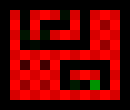

In [21]:
example = random.randrange(x_train.shape[0])
exampleFrame = 32
input_data = np.array([x_train[example,0:exampleFrame,::,::,::]])
prediction = model.predict(input_data)
print(prediction.shape)
prediction = prediction[0, -1, ::]
print(prediction.shape)
prediction = linesToDotsAndBoxesImage(prediction, x_train.shape[-2], x_train.shape[-3])
print(prediction.shape)

print("input:")
print(x_train.shape)
print(x_train[example,exampleFrame,::,::,0])

print("prediction:")
print(prediction)

# create image
target_imgdata = x_train[example,exampleFrame,::,::,0]
target_imgdata = target_imgdata.astype(np.uint8)

prediction_imgdata = prediction * 255
prediction_imgdata = prediction_imgdata.astype(np.uint8)

# merge image data in color channels
tmp = np.zeros(prediction.shape, dtype=np.uint8)
merged_imgdata = np.stack([target_imgdata, prediction_imgdata, tmp], axis=2)
merged_imgdata_large = np.append(target_imgdata, prediction_imgdata, axis=1)
print(merged_imgdata.shape)

#create image
img = Image.fromarray(merged_imgdata, 'RGB')
#img = Image.fromarray(merged_imgdata_large, 'P')
img = img.resize(size=(img.size[0]*10, img.size[1]*10))

img

In [ ]:
target_imgdata = x_train[example,:,:,0] * 255
target_imgdata = target_imgdata.astype(np.uint8)

prediction_imgdata = prediction[0] * 255
prediction_imgdata = prediction_imgdata.astype(np.uint8)

# merge image data in color channels
tmp = np.zeros((prediction[0].shape[0], prediction[0].shape[1]), dtype=np.uint8)
merged_imgdata = np.stack([target_imgdata, prediction_imgdata[:,:,1], tmp], axis=2)

#create image
img = Image.fromarray(merged_imgdata, 'RGB')
img = img.resize(size=(img.size[0]*10, img.size[1]*10))

img